h-values      | Standard Deviation
--------------|-------------------
0.009         | 0.0029758500646124347
0.01          | 0.0029342918123054255
0.03          | 0.018799765023801034
0.05          | 0.055463971763004195
0.07          | 0.10101926347659966
0.09          | 0.1850922618135778
1.01          | 1.5604611104098522e+64
1.03          | 4.49349793302182e+71
1.05          | 2.3670223918063236e+56
1.1           | 2.4659313453831525e+56
12            | 5.841895301329708e+75
1.3           | 1.1017426915244349e+64
1.4           | 2.723838945477375e+64


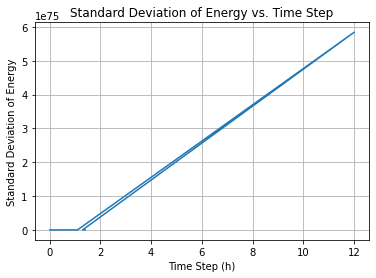

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def my_kinetic_energy(vel, mass):
  """ Calculate total kinetic energy.

  Args:
    vel (np.array): particle velocities, shape (nparticle, ndim)
    mass (float): particle mass
  Return:
    float: total kinetic energy
  """
  total_kinetic_energy = 0
  for velocity in vel:
      total_kinetic_energy += (0.5)*mass*(velocity[0]**2 + velocity[1]**2 + velocity[2]**2)
      
  return total_kinetic_energy

def my_pos_in_box(pos, lbox):
  """ wrap positions inside simulation box

  Args:
    pos (np.array): positions, shape (natom, ndim)
    lbox (float): box side length
  Returns:
    np.array: pos in box
  """
  pos = pos - lbox/2
  pos = -lbox/2 + (pos % lbox)
  return pos

def my_potential_energy(rij):
  """ Calculate total potential energy.
  
  Args:
    rij (np.array): distance table, shape (nparticles, nparticles)
  Return:
    float: total potential energy
  """
  potential_energy = 0.0
  EPSILON = 1e-10
  for i in range(rij.shape[0]):
      for j in range(rij.shape[1]):
          if j > i:
            if rij[i][j] < EPSILON:  # Avoid computations for very close particles
                continue
            r = 1.0 / rij[i][j]
            potential_energy += 4.0 * (r**6) * (r**6 - 1.0)
  return potential_energy

def my_disp_in_box(drij, lbox):
    """ 
    Impose minimum image condition on displacement vector drij=ri-rj

    Args:
      drij (np.array): length-3 displacement vector ri-rj
      lbox (float): length of cubic cell
    Returns:
      np.array: drij under MIC
    """

    return drij - np.round(drij / lbox) * lbox


def compute_distances(positions, L):
    """ Calculate the distance table with minimum image convention. """
    N = positions.shape[0]
    rij = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                delta = positions[i] - positions[j]
                # Implement the minimum image convention
                delta -= L * np.round(delta / L)
                rij[i, j] = np.linalg.norm(delta)
    return rij




def my_force_on(i, pos, lbox):
    """
    Compute force on particle i

    Args:
      i (int): particle index
      pos (np.array) : particle positions, shape (nparticles, ndim)
      lbox (float): side length of cubic box
    Returns:
      np.array: force on particle i, a length-3 vector
    """
    EPSILON = 1e-10
    
    force = np.zeros(3)
    ri = pos[i]
    
    for j, rj in enumerate(pos):
        if j != i:
            drij = my_disp_in_box(ri - rj, lbox)
            r_sq = np.dot(drij, drij)
            
            if r_sq < EPSILON:
                continue
            r = np.sqrt(r_sq)
            r_inv_6 = 1.0 / (r_sq * r_sq * r_sq)
            magnitude = 24 * r_inv_6 * (2*r_inv_6 - 1) / r_sq
            force += magnitude * drij

    return force



def compute_forces(positions, L):
    """ Compute the forces based on the Lennard-Jones potential. """
    N = positions.shape[0]
    forces = np.zeros_like(positions)
    for i in range(N):
        forces[i] = my_force_on(i, positions, L)
    return forces


# Everyone will start their gas in the same initial configuration.
# ----------------------------------------------------------------
def InitPositionCubic(Ncube, L):
    """Places Ncube^3 atoms in a cubic box; returns position vector"""
    N = Ncube**3
    position = np.zeros((N,3))
    rs = L/Ncube
    roffset = L/2 - rs/2
    n = 0
    # Note: you can rewrite this using the `itertools.product()` function
    for x in range(0, Ncube):
        for y in range(0, Ncube):
            for z in range(0, Ncube):
                if n < N:
                    position[n, 0] = rs*x - roffset 
                    position[n, 1] = rs*y - roffset
                    position[n, 2] = rs*z - roffset 
                n += 1
    return position

def InitVelocity(N, T0, mass=1., seed=1):
    dim = 3
    np.random.seed(seed)
    # generate N x dim array of random numbers, and shift to be [-0.5, 0.5)
    velocity = np.random.random((N,dim))-0.5
    sumV = np.sum(velocity, axis=0)/N  # get the average along the first axis
    velocity -= sumV  # subtract off sumV, so there is no net momentum
    KE = np.sum(velocity*velocity)  # calculate the total of V^2
    vscale = np.sqrt(dim*N*T0/(mass*KE))  # calculate a scaling factor
    velocity *= vscale  # rescale
    return velocity

# The simulation will require most of the functions you have already 
# implemented above. If it helps you debug, feel free to copy and
# paste the code here.

# We have written the Verlet time-stepping functions for you below, 
# `h` is the time step.
# -----------------------------------------------------------------

def VerletNextR(r_t, v_t, a_t, h):
    """Return new positions after one Verlet step"""
    # Note that these are vector quantities.
    # Numpy loops over the coordinates for us.
    r_t_plus_h = r_t + v_t*h + 0.5*a_t*h*h
    return r_t_plus_h

def VerletNextV(v_t,a_t,a_t_plus_h,h):
    """Return new velocities after one Verlet step"""
    # Note that these are vector quantities.
    # Numpy loops over the coordinates for us.
    v_t_plus_h = v_t + 0.5*(a_t + a_t_plus_h)*h
    return v_t_plus_h


# Main Loop.
# ------------------------------------------------------------------------

# R, V, and A are the position, velocity, and acceleration of the atoms
# respectively. nR, nV, and nA are the next positions, velocities, etc.
# There are missing pieces in the code below that you will need to fill in.
# These are marked below with comments:

def simulate(Ncube, T0, L, M, steps, h):
    """Initialize and run a simulation in a Ncube**3 box, for steps"""
    N = Ncube**3
    R = InitPositionCubic(Ncube, L)
    V = InitVelocity(N, T0, M)
    A = np.zeros((N,3))
    E = np.zeros(steps)

    for t in range(steps):
        rij = compute_distances(R, L)
        E[t] = my_kinetic_energy(V, M)
        E[t] += my_potential_energy(rij)
        F = compute_forces(R, L)
        A = F / M
        nR = VerletNextR(R, V, A, h)
        my_pos_in_box(nR, L)  ## from PrairieLearn HW
        
        nF = compute_forces(nR, L)
        nA = nF / M
        nV = VerletNextV(V, A, nA, h)
        
        # update positions:
        R, V = nR, nV
    return E

# You may adjust the gas properties here.
# ---------------------------------------

# mass
M = 48.0

# number of Particles
Ncube = 4
N = Ncube**3

# box side length
L = 4.2323167

# temperature
T0 = 0.728

steps = 1000

h = [0.009, 0.01, 0.03, 0.05, 0.07, 0.09, 1.01, 1.03, 1.05, 1.1, 12, 1.3, 1.4]

std_plot_data = []
for h_val in h:
    E = simulate(Ncube, T0, L, M, steps, h_val)
    std_plot_data.append(np.std(E))


print("h-values      | Standard Deviation")
print("--------------|-------------------")
for h_val, std in zip(h, std_plot_data):
    print(f"{h_val:<14}| {std}")
    
plt.plot(h, std_plot_data)
plt.xlabel('Time Step (h)')
plt.ylabel('Standard Deviation of Energy')
plt.title('Standard Deviation of Energy vs. Time Step')
plt.grid(True)
plt.show()

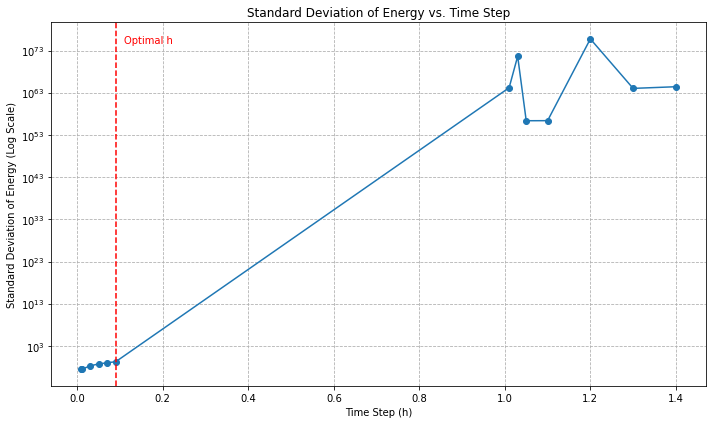

In [39]:
import matplotlib.pyplot as plt

h = [0.009, 0.01, 0.03, 0.05, 0.07, 0.09, 1.01, 1.03, 1.05, 1.1, 1.2, 1.3, 1.4]
std_plot_data = [0.0029758500646124347, 0.0029342918123054255, 0.018799765023801034,
                 0.055463971763004195, 0.10101926347659966, 0.1850922618135778, 
                 1.5604611104098522e+64, 4.49349793302182e+71, 2.3670223918063236e+56, 
                 2.4659313453831525e+56, 5.841895301329708e+75, 1.1017426915244349e+64, 
                 2.723838945477375e+64]

optimal_h = 0.09

plt.figure(figsize=(10,6))
plt.plot(h, std_plot_data, marker='o', linestyle='-')
plt.yscale("log")
plt.xlabel('Time Step (h)')
plt.ylabel('Standard Deviation of Energy (Log Scale)')
plt.title('Standard Deviation of Energy vs. Time Step')

# Highlighting the optimal time step
plt.axvline(x=optimal_h, color='r', linestyle='--')
plt.text(optimal_h+0.02, max(std_plot_data)*0.1, 'Optimal h', rotation=0, color='r')

plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


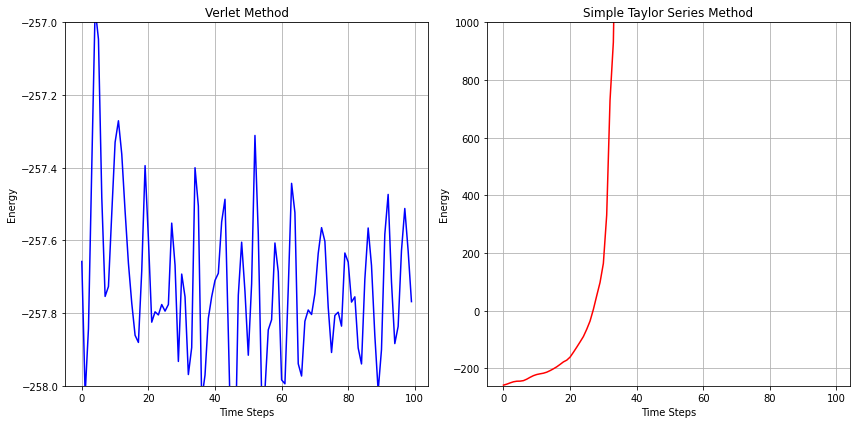

In [44]:
def SimpleNextR(r_t, v_t, a_t, h):
    """Return new positions after one simple integration step"""
    return r_t + v_t*h + 0.5*a_t*h*h

def SimpleNextV(v_t, a_t, h):
    """Return new velocities after one simple integration step"""
    return v_t + a_t*h
def simple_integrate_simulate(Ncube, T0, L, M, steps, h):
    N = Ncube**3
    R = InitPositionCubic(Ncube, L)
    V = InitVelocity(N, T0, M)
    A = np.zeros((N,3))
    E = np.zeros(steps)

    for t in range(steps):
        rij = compute_distances(R, L)
        E[t] = my_kinetic_energy(V, M)
        E[t] += my_potential_energy(rij)
        F = compute_forces(R, L)
        A = F / M
        nR = SimpleNextR(R, V, A, h)
        my_pos_in_box(nR, L)
        
        nF = compute_forces(nR, L)
        nA = nF / M
        nV = SimpleNextV(V, A, h)
        
        R, V = nR, nV
    return E

# You may adjust the gas properties here.
# ---------------------------------------

# mass
M = 48.0

# number of Particles
Ncube = 4
N = Ncube**3

# box side length
L = 4.2323167

# temperature
T0 = 0.728

steps = 100

h = 0.09

# Running simulations
energy_verlet = simulate(Ncube, T0, L, M, steps, h)
energy_taylor = simple_integrate_simulate(Ncube, T0, L, M, steps, h)

# Assuming energy_verlet and energy_taylor are your arrays of energy values
time_steps = range(len(energy_verlet))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Verlet Method
axes[0].plot(time_steps, energy_verlet, color='blue')
axes[0].set_ylim([-258, -257])
axes[0].set_title('Verlet Method')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Energy')
axes[0].grid(True)

# Simple Taylor Series Method
axes[1].plot(time_steps, energy_taylor, color='red')
axes[1].set_title('Simple Taylor Series Method')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Energy')
axes[1].set_ylim([-260, 1000])  # Just an example; adjust as needed
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [43]:
# mass
M = 48.0

# number of Particles
Ncube = 4
N = Ncube**3

# box side length
L = 4.2323167

# temperature
T0 = 0.728

steps = 100

h = 0.09

# Running simulations

E_simple = simple_integrate_simulate(Ncube, T0, L, M, steps, h)
E = simulate(Ncube, T0, L, M, steps, h)
print(E_simple)
print("\n\n\n\n")
print(E)

[-2.57657878e+02 -2.54288714e+02 -2.49950204e+02 -2.46107874e+02
 -2.44116721e+02 -2.43829342e+02 -2.42052255e+02 -2.37000899e+02
 -2.30522305e+02 -2.24791249e+02 -2.20841076e+02 -2.18446164e+02
 -2.16313696e+02 -2.12756228e+02 -2.07344508e+02 -2.01110767e+02
 -1.94165058e+02 -1.85838437e+02 -1.77140691e+02 -1.71150654e+02
 -1.60553154e+02 -1.43813216e+02 -1.26182991e+02 -1.08003110e+02
 -8.92706715e+01 -6.41369502e+01 -3.55590271e+01  4.81924443e+00
  5.21157377e+01  9.82099726e+01  1.64373432e+02  3.31939599e+02
  7.29644901e+02  9.31419382e+02  1.59037437e+03  1.50255207e+04
  2.90932553e+11  1.32357378e+23  1.32357686e+23  1.32357686e+23
  1.57343113e+25  2.41661406e+30  2.41661424e+30  2.41661424e+30
  2.41661424e+30  2.41661425e+30  2.41661458e+30  2.41661472e+30
  2.41661582e+30  2.41665830e+30  2.41665826e+30  2.41665825e+30
  2.41674784e+30  2.41686152e+30  2.41686152e+30  2.41686152e+30
  2.41687241e+30  2.41687241e+30  2.41687241e+30  2.41686806e+30
  2.41686768e+30  2.41686